#### We have a database of FORD vehicles. Let's build a multiple regression model to predict the price of these cars.

#### First, let's import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

#### Read our database and create a Pandas DataFrame.

In [2]:
df_ford = pd.read_csv(r'https://raw.githubusercontent.com/gelono/Data-Analysis/master/ford.csv')
df_ford.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0


#### Check the data for missing values.

In [3]:
df_ford.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

#### There are no missing values. Let's look at descriptive statistics.

In [4]:
print(df_ford.info())
df_ford.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17965 entries, 0 to 17964
Data columns (total 9 columns):
model           17965 non-null object
year            17965 non-null int64
price           17965 non-null int64
transmission    17965 non-null object
mileage         17965 non-null int64
fuelType        17965 non-null object
tax             17965 non-null int64
mpg             17965 non-null float64
engineSize      17965 non-null float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB
None


,year,price,mileage,tax,mpg,engineSize
count,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000,17965.000000
mean,2016.866574,12279.756415,23363.630504,113.334539,57.906991,1.350827
std,2.050346,4741.382606,19472.114690,62.010438,10.125977,0.432371
min,1996.000000,495.000000,1.000000,0.000000,20.800000,0.000000
25%,2016.000000,8999.000000,9987.000000,30.000000,52.300000,1.000000
50%,2017.000000,11291.000000,18243.000000,145.000000,58.900000,1.200000
75%,2018.000000,15299.000000,31064.000000,145.000000,65.700000,1.500000
max,2060.000000,54995.000000,177644.000000,580.000000,201.800000,5.000000


#### We have 3 categorical characteristics (model, transmission, fuelType) and 7 quantitative ones.
#### The year characteristic has an incorrect maximum value. Let's take a closer look at the data in graphical representation.

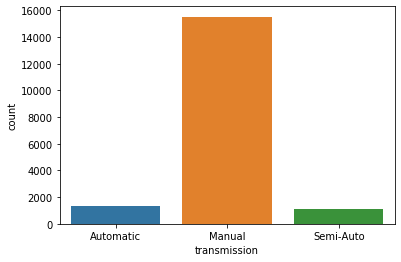

In [5]:
sns.countplot(df_ford['transmission'])

#### Manual transmission vehicles dominate data.

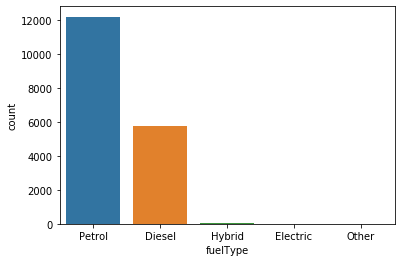

In [6]:
sns.countplot(df_ford['fuelType'])

#### We mainly have gasoline and diesel engines.

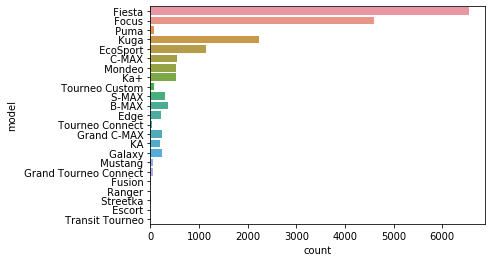

In [7]:
sns.countplot(y = df_ford['model'])

In [8]:
df_ford['model'].value_counts() / len(df_ford['model'])

 Fiesta                   0.364987
 Focus                    0.255385
 Kuga                     0.123852
 EcoSport                 0.063624
 C-MAX                    0.030225
 Ka+                      0.029557
 Mondeo                   0.029279
 B-MAX                    0.019761
 S-MAX                    0.016476
 Grand C-MAX              0.013749
 Galaxy                   0.012691
 Edge                     0.011578
 KA                       0.011077
 Puma                     0.004453
 Tourneo Custom           0.003841
 Grand Tourneo Connect    0.003284
 Mustang                  0.003173
 Tourneo Connect          0.001837
 Fusion                   0.000891
 Streetka                 0.000111
 Escort                   0.000056
 Ranger                   0.000056
 Transit Tourneo          0.000056
Name: model, dtype: float64

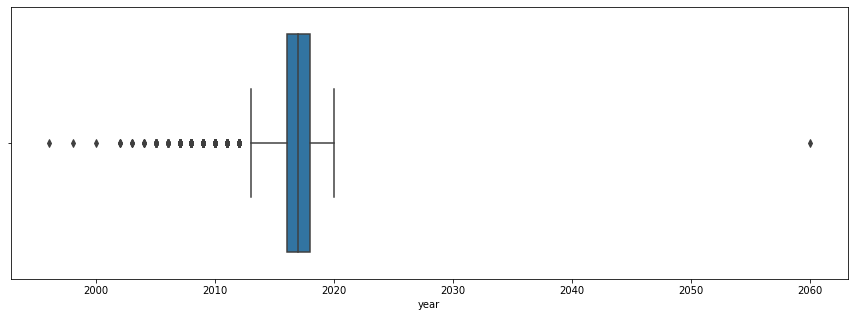

In [9]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['year'])

#### We can assume that the value 2060 is a typo. Let's replace it with 2006.

In [10]:
df_ford.loc[df_ford['year'] > 2020]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
17726,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4


In [11]:
df_ford.at[17726, 'year'] = 2006

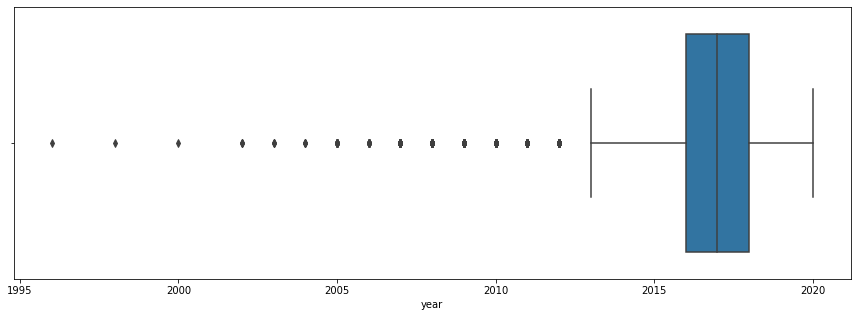

In [12]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['year'])

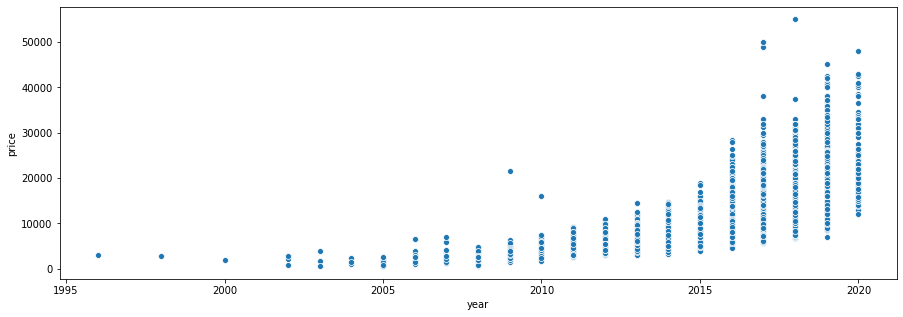

In [13]:
plt.subplots(figsize=(15,5))
sns.scatterplot(df_ford['year'], df_ford['price'])

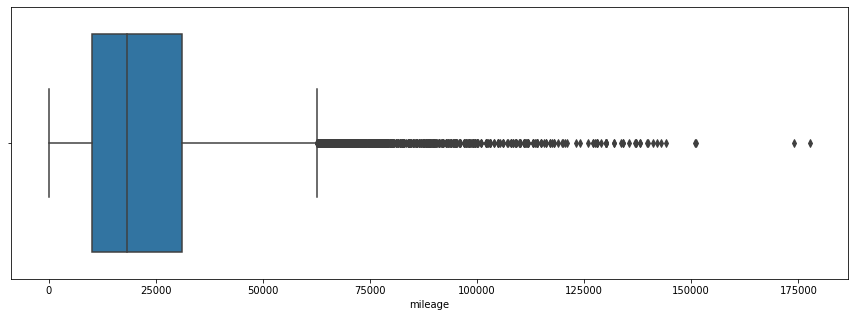

In [14]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['mileage'])

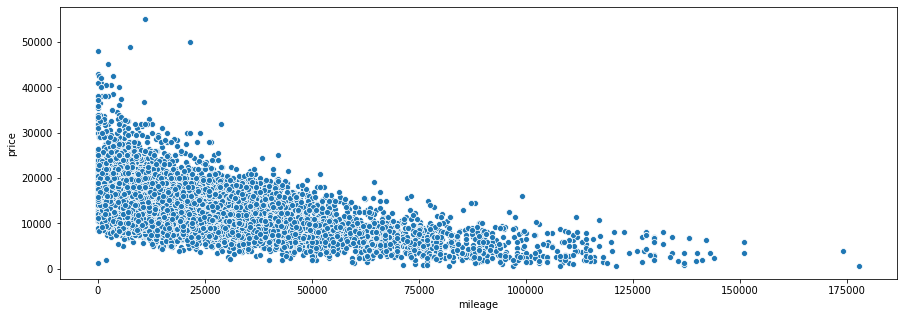

In [15]:
plt.subplots(figsize=(15,5))
sns.scatterplot(df_ford['mileage'], df_ford['price'])

#### There seems to be a relationship between year and mileage. The older the car, the lower its price. And the more mileage, the lower its price. It makes sense that the older the car, the greater its mileage.

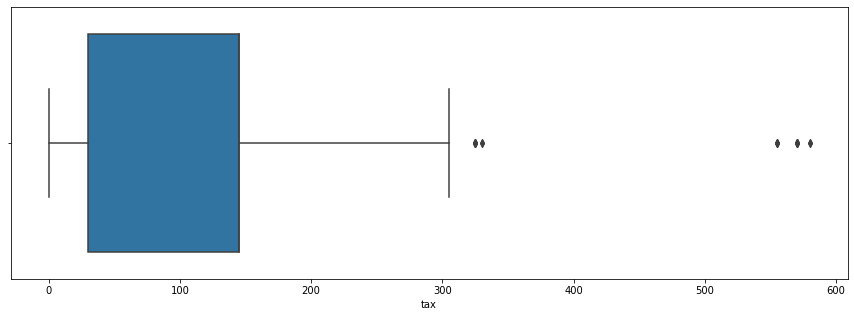

In [16]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['tax'])

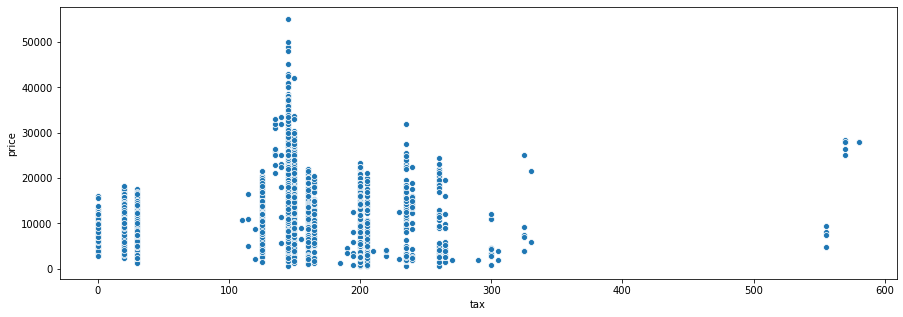

In [17]:
plt.subplots(figsize=(15,5))
sns.scatterplot(df_ford['tax'], df_ford['price'])

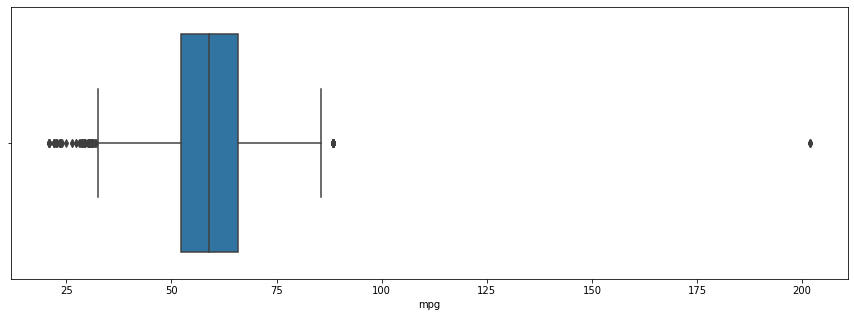

In [18]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['mpg'])

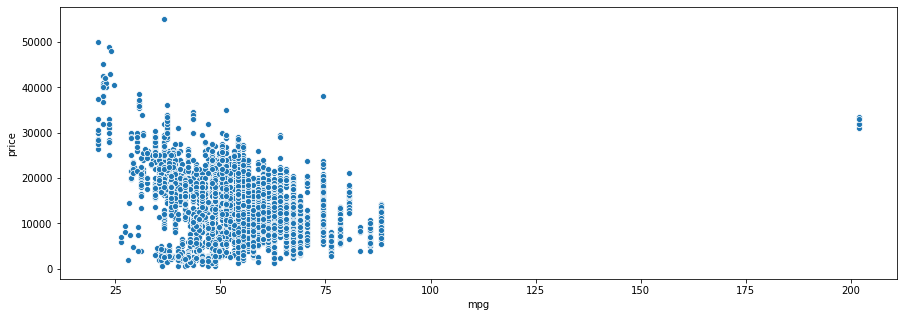

In [19]:
plt.subplots(figsize=(15,5))
sns.scatterplot(df_ford['mpg'], df_ford['price'])

#### It looks like we have an outlier in the mpg characteristic. But, perhaps, this value is a natural phenomenon that refers to the performance of the electric motor.

In [20]:
df_ford.loc[df_ford['mpg'] > 100]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6153,Kuga,2020,31000,Semi-Auto,10,Hybrid,135,201.8,2.5
6536,Kuga,2020,31991,Semi-Auto,2357,Hybrid,135,201.8,2.5
9220,Kuga,2020,32000,Automatic,10,Hybrid,140,201.8,2.5
12862,Kuga,2020,33500,Automatic,5534,Hybrid,140,201.8,2.5
13730,Kuga,2020,32995,Automatic,11,Hybrid,135,201.8,2.5


#### It can be seen that we are dealing with a hybrid engine.

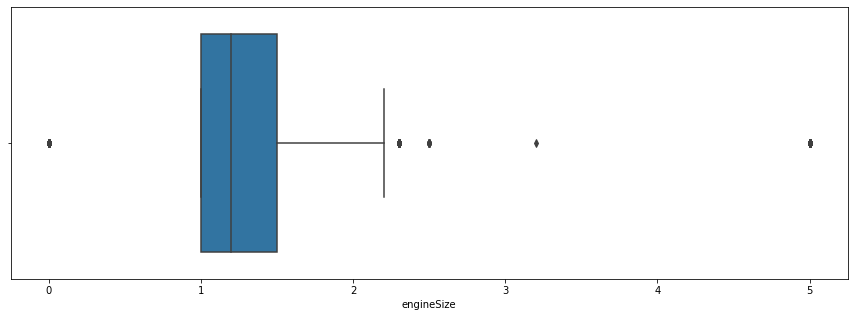

In [21]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['engineSize'])

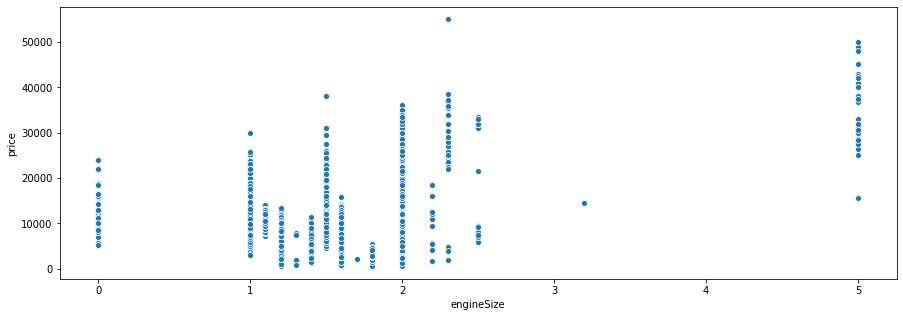

In [22]:
plt.subplots(figsize=(15,5))
sns.scatterplot(df_ford['engineSize'], df_ford['price'])

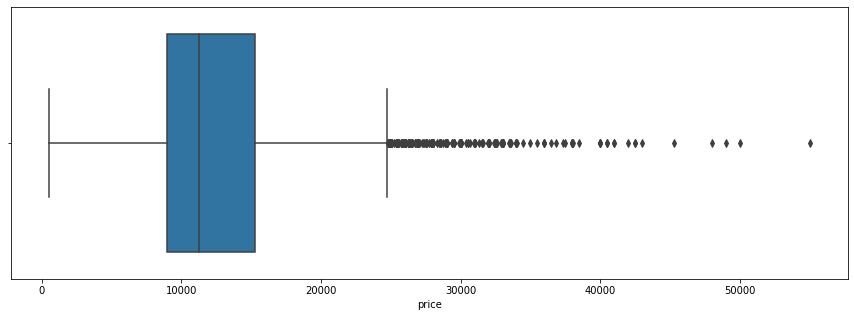

In [23]:
plt.subplots(figsize=(15,5))
sns.boxplot(df_ford['price'])

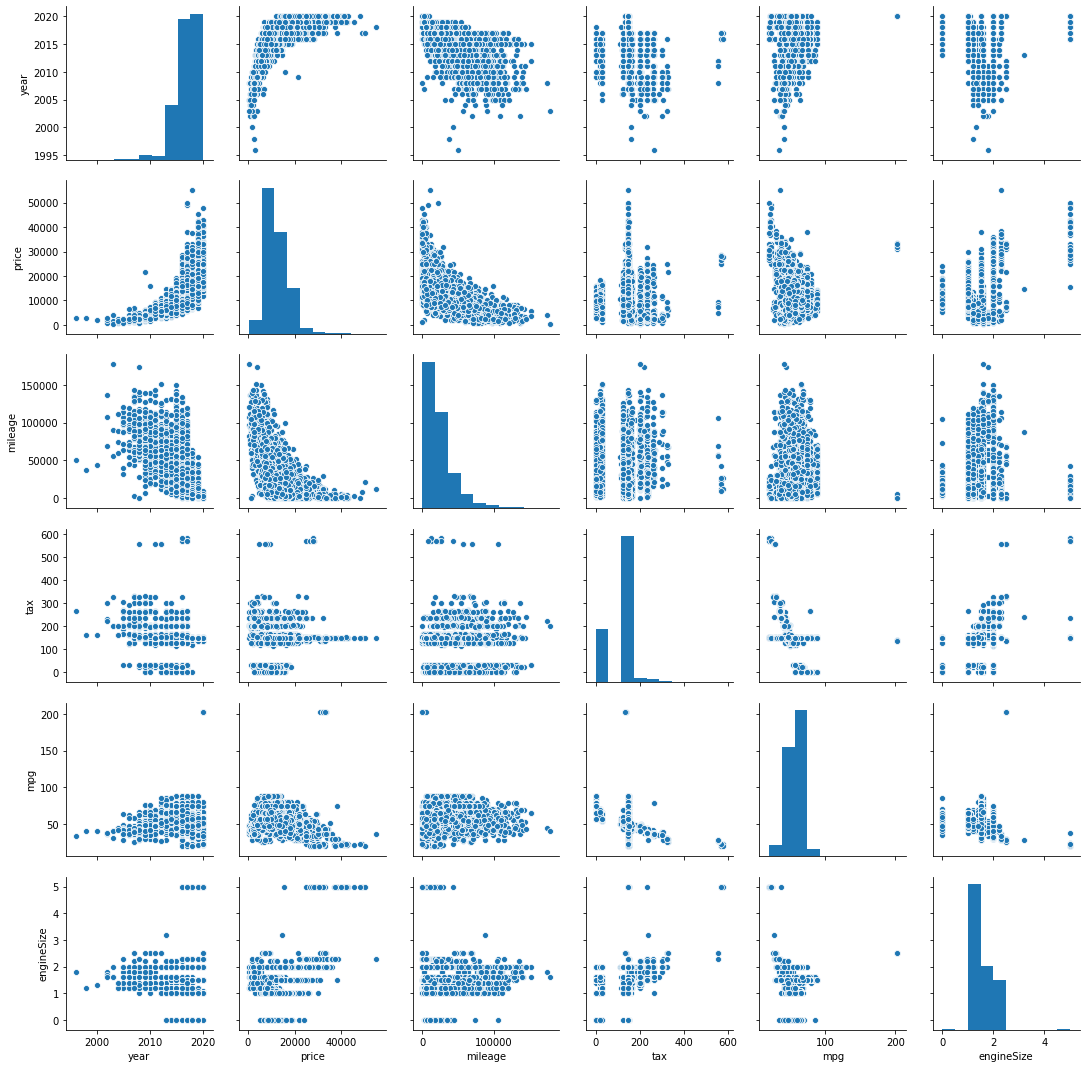

In [24]:
sns.pairplot(df_ford)

#### Let's transform our categorical variables into quantitative ones. For this we use the Dummy technique.

In [25]:
df_ford_dummy = pd.get_dummies(df_ford)
df_ford_dummy.head()

,year,price,mileage,tax,mpg,engineSize,model_ B-MAX,model_ C-MAX,model_ EcoSport,model_ Edge,...,model_ Tourneo Custom,model_ Transit Tourneo,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2017,12000,15944,150,57.7,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2018,14000,9083,150,57.7,1.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2017,13000,12456,150,57.7,1.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,2019,17500,10460,145,40.3,1.5,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2019,16500,1482,145,48.7,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


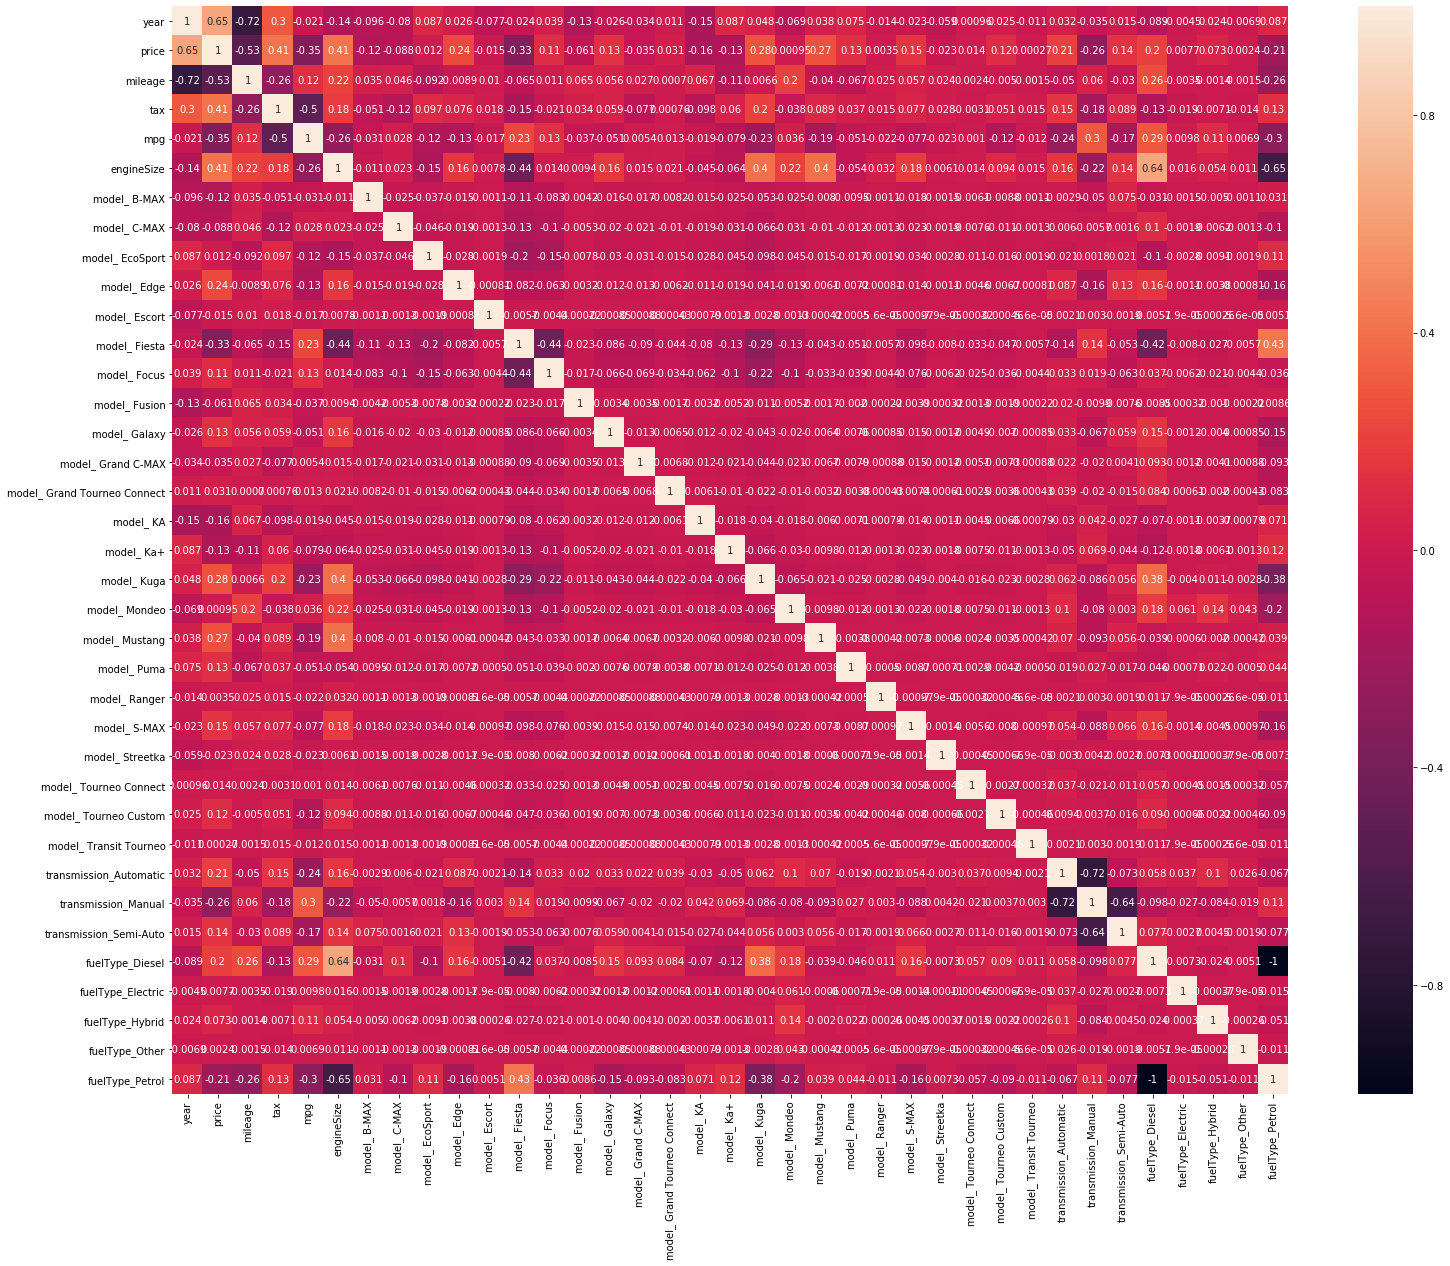

In [26]:
plt.subplots(figsize=(25,20))
sns.heatmap(df_ford_dummy.corr(), vmin=-1, vmax=1, annot = True)

#### To avoid the phenomenon of multicollinearity, we must remove one of the pair of characteristics that have a correlation index greater than 0.7 or less than -0.7. In this case, as we assumed before, there is a relationship between year and mileage. We also see a relationship between Petrol and Diesel. And so are the transmissions.

#### Next, we will standardize our data and divide it into training and test samples.

In [27]:
std = StandardScaler()
df_ford_dummy_std = std.fit_transform(df_ford_dummy)
df_ford_dummy_std = pd.DataFrame(df_ford_dummy_std, columns = df_ford_dummy.columns)
print(df_ford_dummy_std.shape)
df_ford_dummy_std.head()

(17965, 37)


,year,price,mileage,tax,mpg,engineSize,model_ B-MAX,model_ C-MAX,model_ EcoSport,model_ Edge,...,model_ Tourneo Custom,model_ Transit Tourneo,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,0.067324,-0.059005,-0.381049,0.591295,-0.020442,-0.811424,-0.141982,-0.176543,-0.260666,-0.10823,...,-0.062094,-0.007461,3.492829,-2.517666,-0.253778,-0.687153,-0.010552,-0.035016,-0.007461,0.689348
1,0.560787,0.362825,-0.733409,0.591295,-0.020442,-0.811424,-0.141982,-0.176543,-0.260666,-0.10823,...,-0.062094,-0.007461,-0.286301,0.397193,-0.253778,-0.687153,-0.010552,-0.035016,-0.007461,0.689348
2,0.067324,0.151910,-0.560182,0.591295,-0.020442,-0.811424,-0.141982,-0.176543,-0.260666,-0.10823,...,-0.062094,-0.007461,-0.286301,0.397193,-0.253778,-0.687153,-0.010552,-0.035016,-0.007461,0.689348
3,1.054249,1.101027,-0.662691,0.510661,-1.738843,0.345022,-0.141982,-0.176543,-0.260666,-0.10823,...,-0.062094,-0.007461,-0.286301,0.397193,-0.253778,-0.687153,-0.010552,-0.035016,-0.007461,0.689348
4,1.054249,0.890112,-1.123773,0.510661,-0.909270,-0.811424,-0.141982,-0.176543,-0.260666,-0.10823,...,-0.062094,-0.007461,3.492829,-2.517666,-0.253778,-0.687153,-0.010552,-0.035016,-0.007461,0.689348


In [28]:
columns = ['transmission_Manual', 'fuelType_Diesel', 'price', 'mileage']

X_train, X_test, y_train, y_test = train_test_split(df_ford_dummy_std.drop(columns, axis = 1), df_ford_dummy_std['price'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13473, 33)
(4492, 33)
(13473,)
(4492,)


#### Let's build a multiple linear regression model.

In [29]:
#X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     2014.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:15:10   Log-Likelihood:                -7474.8
No. Observations:               13473   AIC:                         1.501e+04
Df Residuals:                   13441   BIC:                         1.525e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
year                             0.6614      0.004    157.949      0.000       0.653       0.670
tax                             -0.0113      0.005     -2.434      0.015      -0.020      -0.002
mpg                             -0.1711      0.007    -24.522      0.000      -0.185      -0.157
engineSize                       0.2567      0.008     31.286      0.000       0.241       0.273
model_ B-MAX                    -0.0639      0.004    -17.333      0.000      -0.071      -0.057
model_ C-MAX                    -0.0372      0.004    -10.098      0.000      -0.044      -0.030
model_ EcoSport                 -0.0298      0.004     -8.057      0.000      -0.037      -0.023
model_ Edge                      0.1541      0.004     38.433      0.000       0.146       0.162
model_ Escort                    0.0313      0.003      9.900      0.000       0.025       0.038
model_ Fiesta                   -0.1138      0.004    -26.286      0.000      -0.122      -0.105
model_ Focus                     0.0729      0.004     20.796      0.000       0.066       0.080
model_ Fusion                    0.0122      0.004      3.190      0.001       0.005       0.020
model_ Galaxy                    0.0981      0.004     26.308      0.000       0.091       0.105
model_ Grand C-MAX              -0.0170      0.004     -4.550      0.000      -0.024      -0.010
model_ Grand Tourneo Connect     0.0186      0.004      5.095      0.000       0.011       0.026
model_ KA                       -0.0524      0.004    -14.595      0.000      -0.059      -0.045
model_ Ka+                      -0.1814      0.004    -50.468      0.000      -0.188      -0.174
model_ Kuga                      0.0958      0.004     21.552      0.000       0.087       0.104
model_ Mondeo                   -0.0174      0.004     -4.627      0.000      -0.025      -0.010
model_ Mustang                   0.1070      0.005     23.135      0.000       0.098       0.116
model_ Puma                      0.0837      0.004     23.217      0.000       0.077       0.091
model_ Ranger                   -0.3703      0.487     -0.760      0.447      -1.325       0.585
model_ S-MAX                     0.1036      0.004     27.525      0.000       0.096       0.111
model_ Streetka                  0.0107      0.003      3.386      0.001       0.005       0.017
model_ Tourneo Connect           0.0108      0.004      3.032      0.002       0.004       0.018
model_ Tourneo Custom            0.0540      0.004     14.484      0.000       0.047       0.061
model_ Transit Tourneo           0.0019      0.003      0.615      0.538      -0.004       0.008
transmission_Automatic           0.0393      0.004     10.013      0.000       0.032       0.047
transmission_Semi-Auto           0.0241      0.004      6.332      0.000    

#### The resulting table contains characteristics that have a pvalue greater than 0.05. This means that these characteristics do not have a significant impact on the price. We will delete them sequentially, starting from the maximum pvalue, each time re-fitting the model again.

In [30]:
X_train_dropped = X_train.copy()
X_test_dropped = X_test.copy()

In [31]:
while True:
    if max(results.pvalues) > 0.05:
        drop_variable = results.pvalues[results.pvalues == max(results.pvalues)]
        print("Dropping " + drop_variable.index[0] + " and running regression again because pvalue is: " + str(drop_variable[0]))
        X_train_dropped = X_train_dropped.drop(columns = [drop_variable.index[0]])
        X_test_dropped = X_test_dropped.drop(columns = [drop_variable.index[0]])
        results = sm.OLS(y_train, X_train_dropped).fit()
    else:
        print("All p values less than 0.05")
        break


Dropping model_ Transit Tourneo and running regression again because pvalue is: 0.5384759457343762
Dropping model_ Tourneo Connect and running regression again because pvalue is: 0.986675861533727
Dropping model_ Kuga and running regression again because pvalue is: 0.6441408548732203
Dropping model_ Grand Tourneo Connect and running regression again because pvalue is: 0.5915175206143584
Dropping model_ Ranger and running regression again because pvalue is: 0.4450055576059959
Dropping model_ Fusion and running regression again because pvalue is: 0.3567632330353747
Dropping fuelType_Other and running regression again because pvalue is: 0.11113902360478864
Dropping fuelType_Electric and running regression again because pvalue is: 0.09713589139103893
All p values less than 0.05


In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.823
Model:                            OLS   Adj. R-squared (uncentered):              0.822
Method:                 Least Squares   F-statistic:                              2497.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):                        0.00
Time:                        16:15:11   Log-Likelihood:                         -7478.4
No. Observations:               13473   AIC:                                  1.501e+04
Df Residuals:                   13448   BIC:                                  1.519e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.6608      0.004    159.642      0.000       0.653       0.669
tax                       -0.0113      0.005     -2.440      0.015      -0.020      -0.002
mpg                       -0.1706      0.007    -24.469      0.000      -0.184      -0.157
engineSize                 0.2567      0.008     31.459      0.000       0.241       0.273
model_ B-MAX              -0.1046      0.004    -25.072      0.000      -0.113      -0.096
model_ C-MAX              -0.0873      0.004    -20.766      0.000      -0.096      -0.079
model_ EcoSport           -0.1012      0.005    -20.528      0.000      -0.111      -0.091
model_ Edge                0.1229      0.004     31.185      0.000       0.115       0.131
model_ Escort              0.0291      0.003      9.199      0.000       0.023       0.035
model_ Fiesta             -0.2548      0.009    -29.289      0.000      -0.272      -0.238
model_ Focus              -0.0546      0.007     -8.024      0.000      -0.068      -0.041
model_ Galaxy              0.0654      0.004     17.438      0.000       0.058       0.073
model_ Grand C-MAX        -0.0510      0.004    -12.988      0.000      -0.059      -0.043
model_ KA                 -0.0831      0.004    -21.023      0.000      -0.091      -0.075
model_ Ka+                -0.2308      0.004    -53.276      0.000      -0.239      -0.222
model_ Mondeo             -0.0662      0.004    -16.266      0.000      -0.074      -0.058
model_ Mustang             0.0907      0.005     19.610      0.000       0.082       0.100
model_ Puma                0.0643      0.004     17.352      0.000       0.057       0.072
model_ S-MAX               0.0665      0.004     17.468      0.000       0.059       0.074
model_ Streetka            0.0076      0.003      2.404      0.016       0.001       0.014
model_ Tourneo Custom      0.0360      0.004      9.817      0.000       0.029       0.043
transmission_Automatic     0.0398      0.004     10.158      0.000       0.032       0.047
transmission_Semi-Auto     0.0241      0.004      6.349      0.000       0.017       0.032
fuelType_Hybrid            0.0568      0.004     15.224      0.000       0.050       0.064
fuelType_Petrol            0.0244      0.009      2.724      0.006       0.007       0.042
==============================================================================
Omnibus:                     3100.442   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20856.102
Skew:                           0.936   Prob(JB):                         0.00
Kurtosis:                       8.800   Cond. No.                         6.30
=========================================

#### We'll use the LinearRegression class to get access to the model's estimate and predicted price values.

In [33]:
regression = LinearRegression()
regression.fit(X_train_dropped, y_train)
print(regression.score(X_train_dropped, y_train))
print(regression.score(X_test_dropped, y_test))

0.8227502596408319
0.8199343789196132


#### Cross-check and compute the average R-squared.

In [34]:
Rcross = cross_val_score(regression, X_train_dropped, y_train, cv = 4)
Rcross

array([0.80434444, 0.82563878, 0.81631249, 0.82936614])

In [35]:
Rcross.mean()

0.8189154606607871

#### We visualize the distributions of the price values of the real test data and the data that our model predicts.

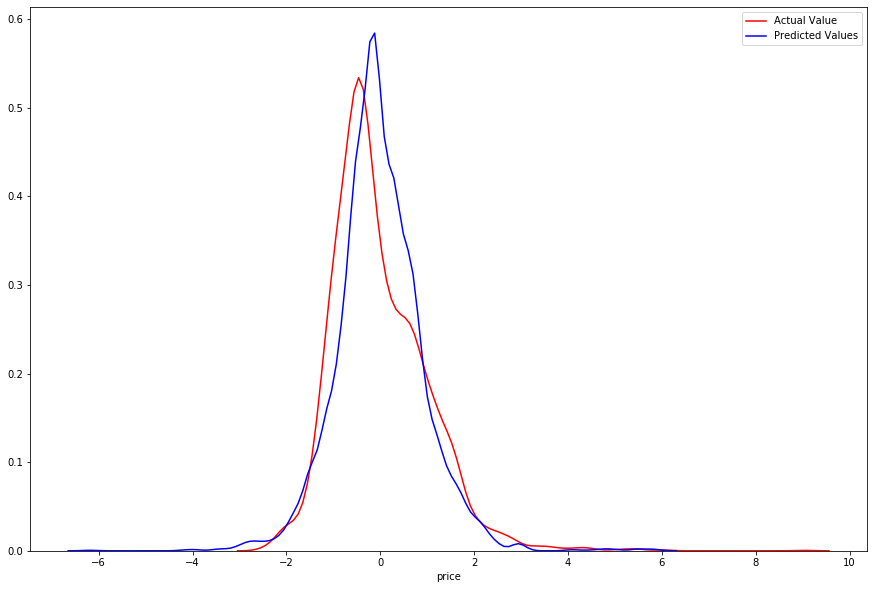

In [36]:
Y_hat = regression.predict(X_test_dropped)
plt.figure(figsize=(15, 10))
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(Y_hat, hist=False, color="b", label="Predicted Values" , ax=ax1)

plt.show()
plt.close()

#### Using multiple linear regression we were able to achieve an average R-Squared of 0.81

### To improve the regression model, we can further turn to nonlinear regression or other types of regression.